In [8]:
from common_functions import ret_metabase, google_sheets, upload_dataframe_to_snowflake, snowflake_query, upload_dataframe_to_pg, dwh_query
import pandas as pd
from datetime import datetime, timedelta
import datetime as dt
import time
import os
import boto3
import base64
from botocore.exceptions import ClientError
import json
import requests
from pathlib import Path
from io import StringIO
import pandas as pd
# import psycopg2
import numpy as np
import gspread
import pytz



def assign_data_equal_projects(df, list):
    """
    Distribute rows of a DataFrame equally among a list of agents, grouped by project name.
    Args:
        df (pd.DataFrame): DataFrame with 'project_name'
        list (list): List of agent IDs or names
    Returns
        pd.DataFrame: DataFrame with 'agent_assigned' column
    """
    df = df.sample(frac=1)  # Shuffle the data
    project_types = df['project_name'].unique()
    
    assigned_data = pd.DataFrame()
    
    for project in project_types:
        project_df = df[df['project_name'] == project]
        project_df = project_df.reset_index(drop=True)
        rows_per_agent = len(project_df) // len(list)
        remainder = len(project_df) % len(list)
        
        # Distribute rows equally
        for i, agent in enumerate(list):
            start_idx = i * rows_per_agent
            end_idx = start_idx + rows_per_agent
            agent_data = project_df.iloc[start_idx:end_idx].copy()
            agent_data['agent_assigned'] = agent
            
            # Handle remainder
            if i < remainder:
                extra_row = project_df.iloc[end_idx:end_idx+1].copy()
                extra_row['agent_assigned'] = agent
                agent_data = pd.concat([agent_data, extra_row])
            
            assigned_data = pd.concat([assigned_data, agent_data])
    
    assigned_data = assigned_data.reset_index(drop=True)
    print("Assignment by project complete.")
    return assigned_data

df = ret_metabase("EGYPT", 63954)
df = df.rename(columns={"TAG": "project_name"})

Agents = google_sheets("Telesales Agents Structure", "Agent", "get")
Active_agents = Agents[Agents["status"] == "Active"]

available_agents_list = Active_agents['eagle_eye_id'].values.tolist()
total = len(available_agents_list) * 250
print(total)

df = df.head(total)

dispatched_data = assign_data_equal_projects(df, available_agents_list)
dispatched_data["MOBILE"] = dispatched_data["MOBILE"].astype(str)

def format_mobile(x):
    if x.startswith("+20"):
        return "0" + x[3:]   # remove +20 and replace with 0
    elif x.startswith("0"):
        return x             # already correct
    else:
        return "0" + x       # force prepend 0 if missing

dispatched_data["MOBILE"] = dispatched_data["MOBILE"].apply(format_mobile)

now = datetime.now() + timedelta(hours=3)

data_for_SF = dispatched_data.copy()
data_for_SF.rename(columns={"RETAILER_ID": "main_system_id"}, inplace=True)
data_for_SF['description'] = ''
data_for_SF['dispatched_at'] = now
data_for_SF = data_for_SF[["RETAILER_NAME",
    "main_system_id", "project_name", "description", "agent_assigned",
    "dispatched_at", "LAST_CALL", "LAST_VISIT", "LAST_ORDER", "AVG_TS", "MOBILE", "PRIORITY"
]]

upload_dataframe_to_snowflake("Egypt", data_for_SF, "MATERIALIZED_VIEWS", "Telesales_ecom_generated_data", "append")



/home/ec2-user/service_account_key.json
/home/ec2-user/service_account_key.json
3250
Assignment by project complete.
/home/ec2-user/service_account_key.json


True

In [18]:
def assign_data_equal_projects(df, list):
    """
    Distribute rows of a DataFrame equally among a list of agents, grouped by project name.
    Args:
        df (pd.DataFrame): DataFrame with 'project_name'
        list (list): List of agent IDs or names
    Returns
        pd.DataFrame: DataFrame with 'agent_assigned' column
    """
    df = df.sample(frac=1)  # Shuffle the data
    project_types = df['project_name'].unique()
    
    assigned_data = pd.DataFrame()
    
    for project in project_types:
        project_df = df[df['project_name'] == project]
        project_df = project_df.reset_index(drop=True)
        rows_per_agent = len(project_df) // len(list)
        remainder = len(project_df) % len(list)
        
        # Distribute rows equally
        for i, agent in enumerate(list):
            start_idx = i * rows_per_agent
            end_idx = start_idx + rows_per_agent
            agent_data = project_df.iloc[start_idx:end_idx].copy()
            agent_data['agent_assigned'] = agent
            
            # Handle remainder
            if i < remainder:
                extra_row = project_df.iloc[end_idx:end_idx+1].copy()
                extra_row['agent_assigned'] = agent
                agent_data = pd.concat([agent_data, extra_row])
            
            assigned_data = pd.concat([assigned_data, agent_data])
    
    assigned_data = assigned_data.reset_index(drop=True)
    print("Assignment by project complete.")
    return assigned_data



In [6]:
df = ret_metabase("EGYPT", 63954)
df = df.rename(columns={"TAG": "project_name"})
df

/home/ec2-user/service_account_key.json


,RETAILER_NAME,MOBILE,RETAILER_ID,project_name,LAST_ORDER,TELESALES_DEPENDENT,LAST_CALL,AVG_TS,LAST_VISIT,MP_ORDER_COUNT_SEPTEMBER,PRIORITY
0,عطاره خان الخليلى,1228125310,433191,marketplace retention,2025-08-02T13:26:42.832,1,2025-08-27T16:52:06.094,3526.785744,2025-08-02T16:22:00.442,0,1
1,علاء,1270477398,502570,marketplace retention,2025-08-02T10:17:37.561,1,2025-08-24T21:10:00.337,3366.612204,2025-08-09T13:01:50.31,0,2
2,احمد شكري,1111625020,218567,instock churned last month p1,2025-08-02T16:48:58,1,2025-08-25T17:20:57.514,5717.262523,2025-04-26T13:50:28.488,0,3
3,عبودة,1062425853,39521,marketplace retention,2025-08-02T15:07:00.52,1,2025-08-26T18:36:40.458,2821.437473,2025-08-02T17:37:56.501,0,4
4,كريم الخولي,1221717400,352693,marketplace retention,2025-08-02T17:45:00.309,1,2025-08-24T15:53:44.807,2773.894026,2025-08-02T20:42:23.789,0,5
...,...,...,...,...,...,...,...,...,...,...,...
46479,مسعد,1015672455,187537,instock reactivation,2025-07-30T22:37:17,0,2025-08-26T13:32:55.417,821.336100,2025-07-30T21:30:01.7,0,46480
46480,Sarah,1204047090,903707,instock reactivation,2025-07-29T09:56:20,0,2025-08-14T13:28:05.832,737.500000,1999-02-10,0,46481
46481,ام كريم,1067887132,900070,instock reactivation,2025-07-28T09:33:03,0,2025-08-11T14:20:12.251,633.500000,2025-08-31T23:12:56.228,0,46482
46482,ام عرفه,1153044216,740091,instock reactivation,2025-07-27T00:36:56,0,2024-12-26T16:50:25.141,587.687500,2025-08-30T11:59:05.784,0,46483


In [20]:
Agents = google_sheets("Telesales Agents Structure", "Agent", "get")


/home/ec2-user/service_account_key.json


In [21]:
Active_agents = Agents[Agents["status"] == "Active"]
Active_agents

,Maxer ID,agent_name,eagel_eye_id,three_cx_id,Email,National ID,Mobile_Number,Supervisor,status,status_id,...,Daily Wage,Bonus | Sep,Deduction | Sep,Employee Name,Basic Salary.1,Variable.1,Total,Daily Wage.1,Bonus | May,Deduction | May
0,100068,Mona Assem,88.0,110.0,mona@maxab.io,2.960502e+13,1.285049e+09,Samar,Active,1.0,...,206.666667,NaN,NaN,Samar Abdel Naby Sayed,14542.0,6115.0,20657.0,484.733333,1454.2,NaN
1,100043,Rania Arafa,54.0,106.0,rania.arafa@maxab.io,2.890817e+13,1.271418e+09,Samar,Active,1.0,...,207.500000,NaN,NaN,Asmaa Yassin Fathy Mohamed,12820.0,5454.0,18274.0,427.333333,1282.0,NaN
2,119616,Safiya Hassan,1280.0,328.0,safiya.hassan@maxab.io,2.910504e+13,1.285049e+09,Asmaa,Active,1.0,...,201.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,134696,Ahmed Khedr,2643.0,123.0,ahmed.morsi@maxab.io,2.970704e+13,1.126918e+09,Samar,Active,1.0,...,208.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-,Maha Mahmoud,2840.0,142.0,maha.mahmoud@maxab.io,2.960323e+13,1.114404e+09,Samar,Active,1.0,...,201.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-,Esraa Saied,2839.0,141.0,esraa.saied@maxab.io,3.020418e+13,1.002388e+09,Samar,Active,1.0,...,201.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,102054,Rania Mohamed,667.0,246.0,rania.mohamed@maxab.io,2.960803e+13,1.285049e+09,Asmaa,Active,1.0,...,202.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,-,Rahma Essam,2913.0,113.0,Rahma.Essam@maxab.io,2.980119e+13,1.142855e+09,Samar,Active,1.0,...,201.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-,Esraa Ramadan,2912.0,148.0,esraa.ramadan@maxab.io,2.980525e+13,1.124008e+09,Samar,Active,1.0,...,201.100000,NaN,402.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,101732,Warda Adel,639.0,239.0,warda.adel@maxab.io,2.960813e+13,1.014924e+09,Samar,Active,1.0,...,202.866667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
available_agents_list = Active_agents['eagel_eye_id'].values.tolist()
total = len(available_agents_list) * 250
print(total)

3250


In [23]:

df = df.head(total)

In [24]:
dispatched_data = assign_data_equal_projects(df, available_agents_list)



Assignment by project complete.


In [25]:
dispatched_data["MOBILE"] = dispatched_data["MOBILE"].astype(str)

def format_mobile(x):
    if x.startswith("+20"):
        return "0" + x[3:]   # remove +20 and replace with 0
    elif x.startswith("0"):
        return x             # already correct
    else:
        return "0" + x       # force prepend 0 if missing

dispatched_data["MOBILE"] = dispatched_data["MOBILE"].apply(format_mobile)


In [26]:
pivot = dispatched_data.pivot_table(
    index="agent_assigned",
    columns="project_name",
    values="PRIORITY",   # or any column
    aggfunc="count",
    fill_value=0
)


In [27]:
# Calculate the difference (max - min) for each project
diff_row = pivot.max() - pivot.min()

# Add it as a new row called "Difference"
pivot.loc["Difference"] = diff_row

pivot

project_name,ecom reactivation,ecom retention,marketplace acquisition,marketplace reactivation,marketplace retention
agent_assigned,,,,,
54.0,38,25,100,38,50
88.0,38,25,101,38,50
639.0,37,25,100,37,50
667.0,37,25,100,37,50
1280.0,38,25,100,38,50
2407.0,37,25,100,37,50
2643.0,38,25,100,38,50
2839.0,38,25,100,38,50
2840.0,38,25,100,38,50


In [28]:
now = datetime.now() + timedelta(hours=3)

In [29]:
data_for_SF = dispatched_data.copy()
data_for_SF.rename(columns={"RETAILER_ID": "main_system_id"}, inplace=True)
data_for_SF['description'] = ''
data_for_SF['dispatched_at'] = now
data_for_SF = data_for_SF[["RETAILER_NAME",
    "main_system_id", "project_name", "description", "agent_assigned",
    "dispatched_at", "LAST_CALL", "LAST_VISIT", "LAST_ORDER", "AVG_TS", "MOBILE", "PRIORITY"
]]


In [30]:
upload_dataframe_to_snowflake("Egypt", data_for_SF, "MATERIALIZED_VIEWS", "Telesales_ecom_generated_data", "append")

/home/ec2-user/service_account_key.json


True

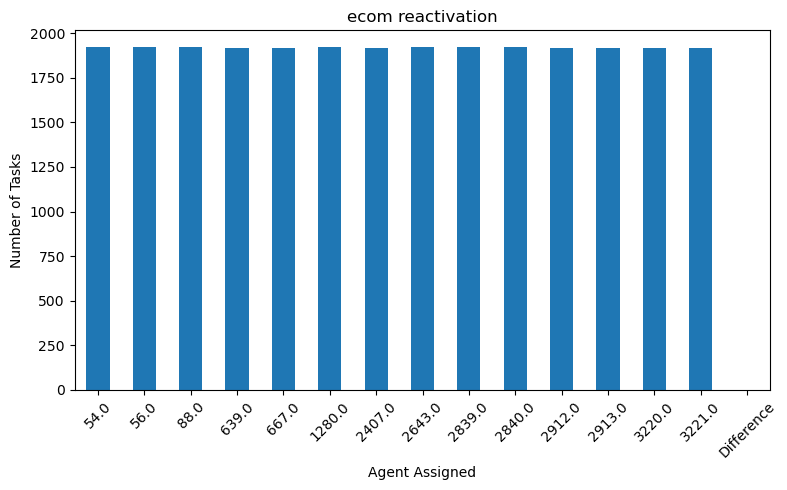

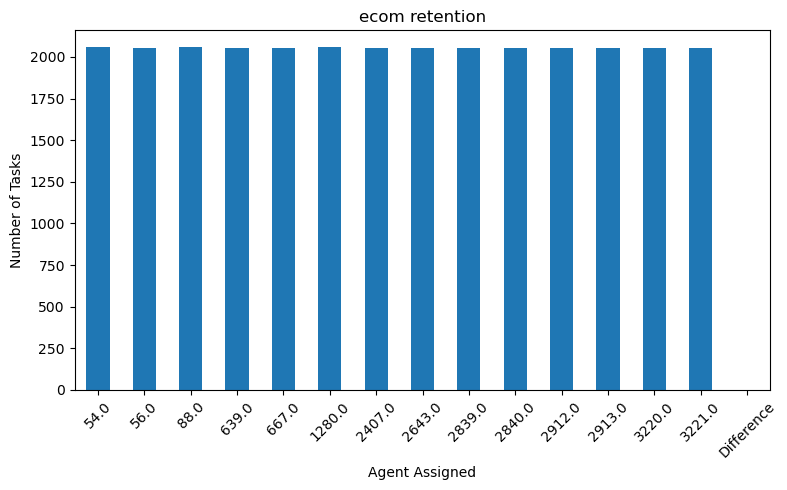

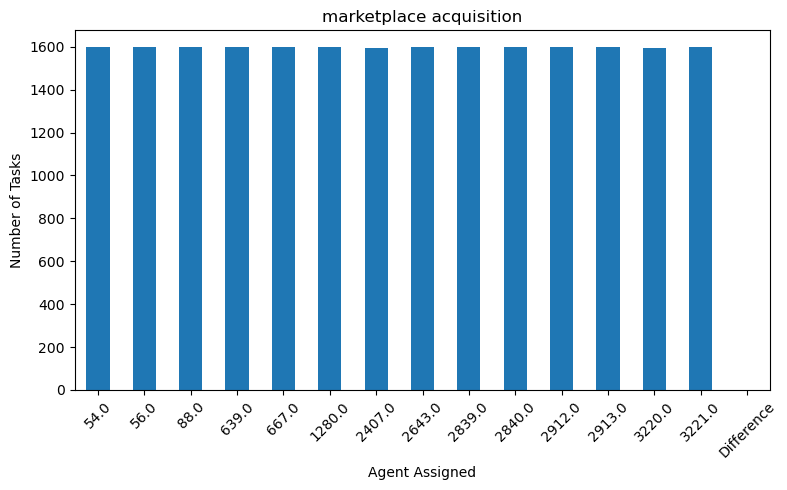

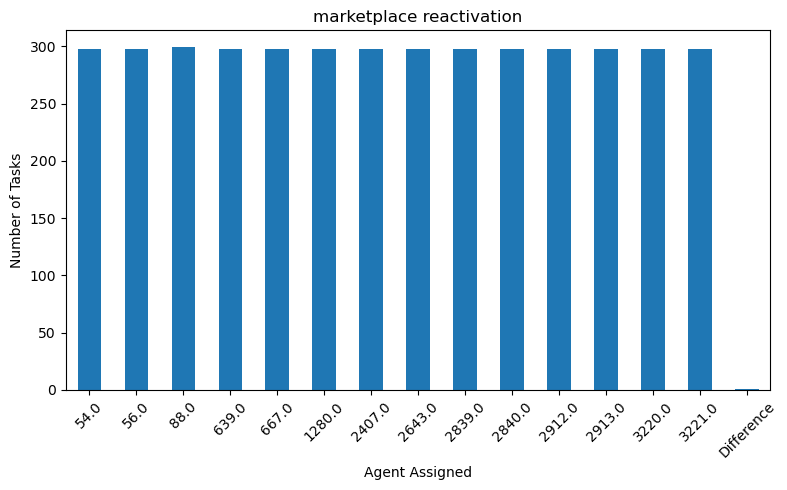

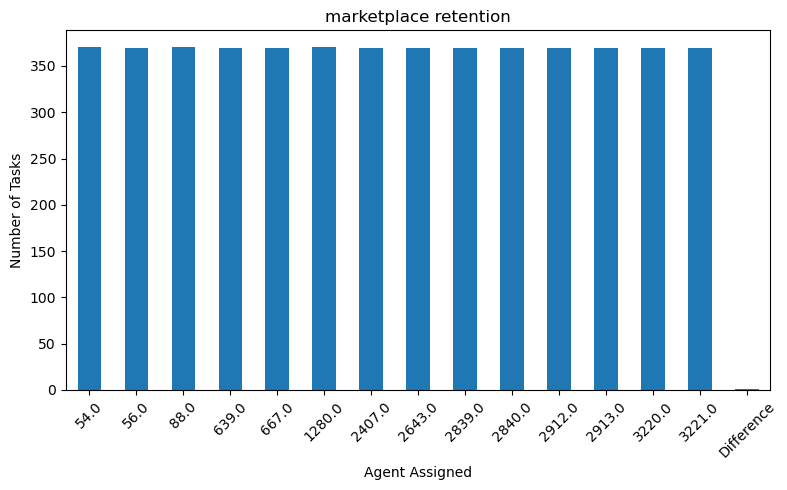

In [28]:
import matplotlib.pyplot as plt

# Loop through each project (i.e., each column in the pivot table)
for project in pivot.columns:
    plt.figure(figsize=(8,5))
    pivot[project].plot(kind="bar")
    plt.title(f"{project}")
    plt.xlabel("Agent Assigned")
    plt.ylabel("Number of Tasks")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [29]:
import pandas as pd
import numpy as np

df_for_dwh = pd.DataFrame({
    "Task_id": pd.Series(dtype=np.int32),  # force 32-bit int
    "Status": pd.Series(dtype="string"),
})

df_for_dwh

,Task_id,Status,Checks


In [26]:
# Example dummy record
dummy_row = {
    "Task_id": 1,
    "Status": "PENDING",
    "Checks": "YES"
}

# Append row
df_for_dwh = pd.concat([df_for_dwh, pd.DataFrame([dummy_row])], ignore_index=True)

print(df_for_dwh)


   Task_id   Status Checks
0        1  PENDING    YES


In [24]:
from common_functions import upload_dataframe_to_pg

In [30]:
upload_dataframe_to_pg(df_for_dwh, "Egypt", "replace", "materialized_views", "sales_approval_submission", db_conn=None)

/home/ec2-user/service_account_key.json


In [14]:
dff = snowflake_query("Egypt", "select * from materialized_views.Telesales_ecom_generated_data", warehouse=None, columns=[], conn=None)
dff

/home/ec2-user/service_account_key.json


,retailer_name,main_system_id,project_name,description,agent_assigned,dispatched_at,last_call,last_visit,last_order,avg_ts,mobile,priority
0,مصطفى كاظم,420451,marketplace retention,,88.0,2025-08-20 15:30:12.181614,2025-07-14T13:33:06.429,2025-07-16T18:34:09.491,2025-07-28T03:06:43,5075.71875,+201282558313,2489
1,بيتر منصور (ماركت افندينا ),339431,marketplace retention,,88.0,2025-08-20 15:30:12.181614,1999-02-10,2025-07-28T13:29:12.724,2025-07-28T10:50:07.178,3669.0,+201020382740,3054
2,عبد السميع محمد,79015,marketplace retention,,88.0,2025-08-20 15:30:12.181614,2025-06-19T17:34:41.552,2025-07-26T18:44:42.243,2025-07-26T13:27:50.73,5461.781667,+201099003308,643
3,ابو يوسف,254234,marketplace retention,,88.0,2025-08-20 15:30:12.181614,2025-07-01T14:33:11.076,2025-07-28T20:19:17.509,2025-07-21T17:50:04.536,3328.666667,+201120242412,1094
4,عطارة الفتح,534917,marketplace retention,,88.0,2025-08-20 15:30:12.181614,2025-07-02T18:42:24.955,2025-08-06T14:57:35.591,2025-07-24T09:15:09,3167.535417,+201210388880,1169
...,...,...,...,...,...,...,...,...,...,...,...,...
27745,مسعد عبد اللطيف شلبي,176154,ecom reactivation,,3220.0,2025-08-28 10:25:30.392662,1999-02-10,2025-07-22T13:37:42.803,2025-05-10T16:17:54,1005.81005,01205981092,2384
27746,عم احمد,451652,ecom reactivation,,3220.0,2025-08-28 10:25:30.392662,2025-08-10T14:49:15.036,2025-08-12T16:11:48.046,2025-04-29T16:19:53,1542.328333,01275722204,696
27747,عمر,508440,ecom reactivation,,3220.0,2025-08-28 10:25:30.392662,2024-08-25T11:48:23.006,2025-08-14T16:26:04.02,2025-05-02T02:08:43,3319.47,01061951947,511
27748,ام احمد,591602,ecom reactivation,,3220.0,2025-08-28 10:25:30.392662,2025-04-10T17:30:41.825,2025-07-13T15:40:46.47,2025-04-08T19:35:49,1380.076667,01002455332,84


In [15]:
import pandas as pd

# Add new column with empty string as default
dff["call_later"] = ""

# Ensure dtype is string (object in pandas → VARCHAR in Snowflake)
dff["call_later"] = dff["call_later"].astype(str)

# Check dtype
print(dff.dtypes)


retailer_name             object
main_system_id            object
project_name              object
description               object
agent_assigned            object
dispatched_at     datetime64[ns]
last_call                 object
last_visit                object
last_order                object
avg_ts                    object
mobile                    object
priority                  object
call_later                object
dtype: object


In [16]:
upload_dataframe_to_snowflake("Egypt", dff, "MATERIALIZED_VIEWS", "Telesales_ecom_generated_data", "overwrite")

/home/ec2-user/service_account_key.json


True